In [13]:
import sys
sys.path.append('../code/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from mamba_ssm import Mamba

import utils
from train_ann_sweep import get_generators
import pickle

device = torch.device("cuda:0")
# device = torch.device("cpu")

In [62]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]

df = pd.read_pickle('../data/developmental_df.pkl')
n_subjects = len(np.unique(df['subj'].values))

time_series = df.iloc[:,:-1].values

correlation_matrix = np.corrcoef(time_series.T)

In [7]:
with open('../data/ann_bottleneck_sweep_results.pkl', 'rb') as f:
    metadata = pickle.load(f)
print(metadata['bottleneck_values'])

[1, 3, 5, 7, 9, 11, 13, 15]


In [19]:
fold = 0
bottleneck = 7
input_size = 40
encoder_layer_size = [500, 300, 100]
decoder_layer_size = encoder_layer_size[::-1]


model = utils.model_ann_autoencoder(input_size, encoder_layer_size, decoder_layer_size, bottleneck=bottleneck).to(device)
state_dict = torch.load('../models/ann/bottleneck/ann_fold0_bottleneck7.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [82]:
n_regions = len(labels)
coords = np.array(atlas.region_coords)
functional_networks = list()
coords_list = list()

std_threshold = 1.5

for bottleneck_idx in range(bottleneck):
    bottleneck_input = torch.zeros((1, 100, bottleneck)).to(device)
    bottleneck_input[0,:,bottleneck_idx] = torch.linspace(-10, 10, 100)

    decoder_output = model.decoder(bottleneck_input).detach().cpu().numpy()

    decoder_std = np.std(decoder_output[0,:,:], axis=0)
    region_idx = np.where(decoder_std > std_threshold)[0]

    num_nodes = len(region_idx)
    temp_network = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            node1, node2 = region_idx[i], region_idx[j]
            temp_network[i, j] = correlation_matrix[node1, node2]
    
    functional_networks.append(temp_network)
    coords_list.append(coords[np.in1d(range(n_regions),region_idx), :])


In [83]:
np.std(decoder_output[0,:,:],axis=0)

array([1.440445  , 0.16163743, 0.48895395, 1.2733436 , 0.18634976,
       0.34743145, 2.096373  , 0.5249708 , 0.3675363 , 1.1778738 ,
       0.76566434, 2.2827394 , 1.263339  , 0.39348882, 1.7190475 ,
       0.95580894, 1.9952532 , 0.21360867, 1.0364761 , 1.0249536 ,
       0.16201568, 1.1204616 , 0.5358518 , 0.72464997, 0.28380787,
       0.56174564, 1.2173718 , 1.3787887 , 0.5857916 , 1.8469511 ,
       0.10657179, 1.8831536 , 1.3248421 , 0.8853359 , 0.93294066,
       0.05044317, 1.5394074 , 2.702327  , 1.5890077 , 0.15231444],
      dtype=float32)

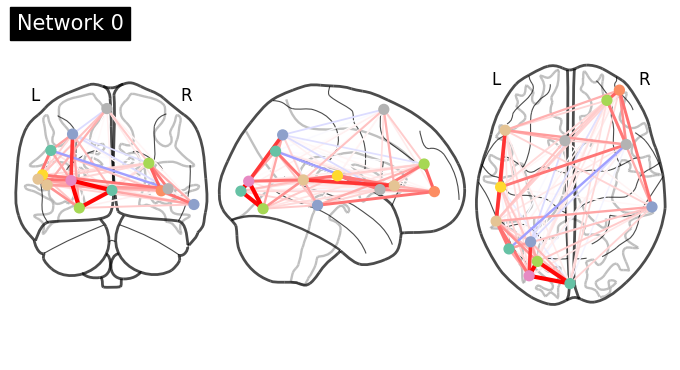

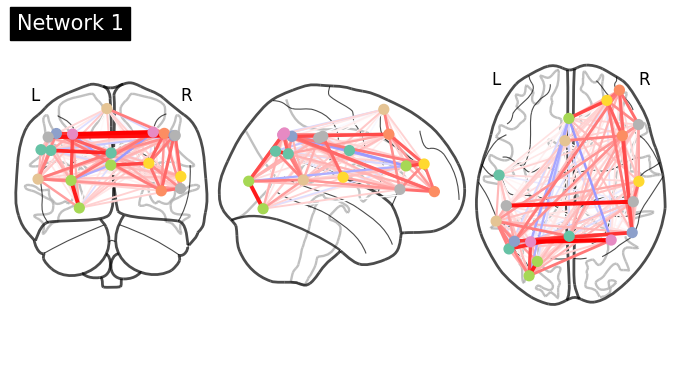

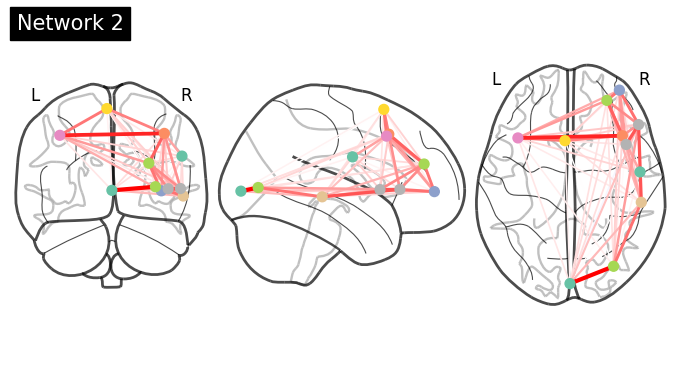

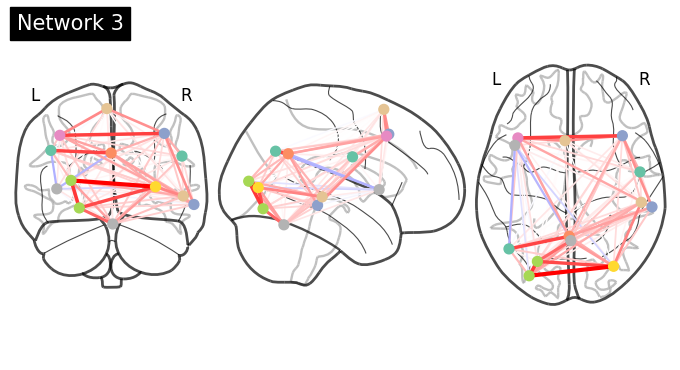

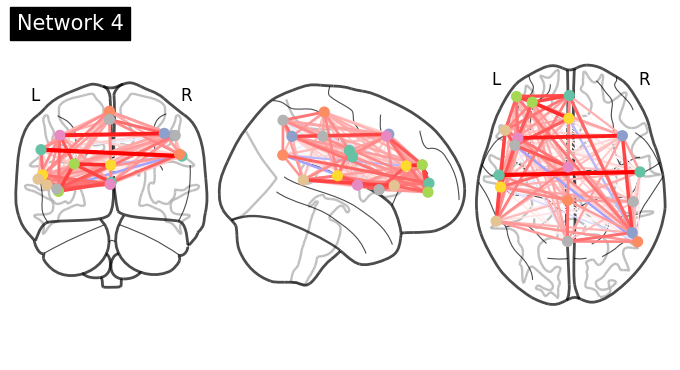

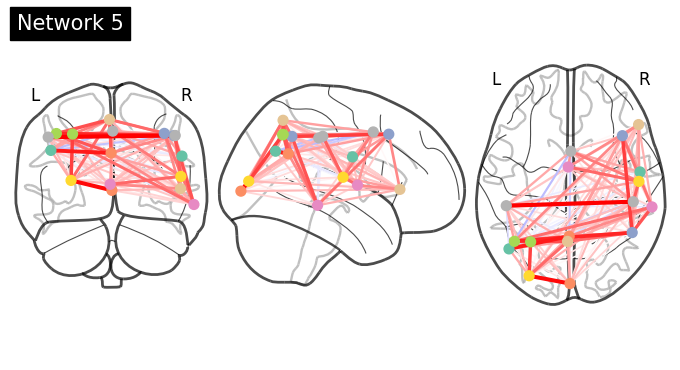

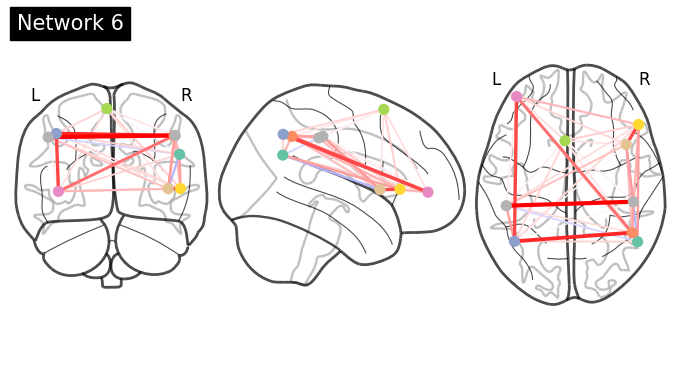

In [84]:
coords = atlas.region_coords

for net_idx in range(bottleneck):
    plotting.plot_connectome(functional_networks[net_idx], coords_list[net_idx], title=f'Network {net_idx}')
# plotting.show()

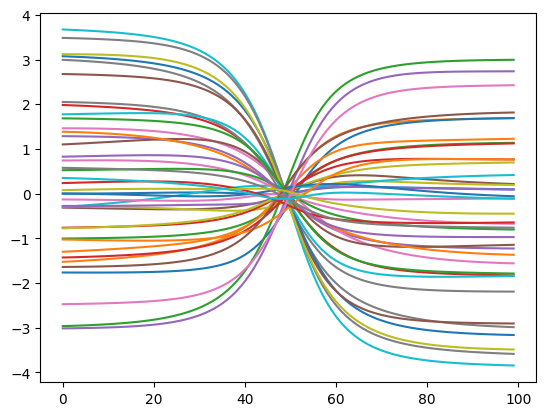

In [54]:
_ = plt.plot(decoder_output[0,:,:])